In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

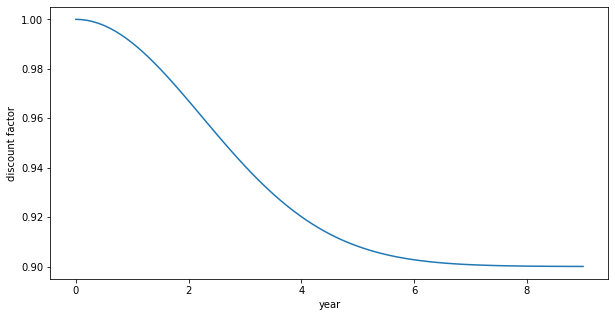

In [2]:
#計算ロジック上必要な値

#利払い回数
N=20
#利払い間隔(年)
delta_p=0.5
#格子間隔(年)
delta_t=0.1
#権利行使日までの期間(年)
T=1.0
#ストライクレート
S_Rate=0.1


#所与の値
a=0.05
r_init=0
h=3
sigma=0.01

#その他変数定義
N_T=T//delta_t
N=int(N*(delta_p//delta_t)+N_T)
V=sigma**2*delta_t
delta_r=np.sqrt(h*V)
M=-a*delta_t
if a==0:
    Max_node=1000000
else:
    Max_node=np.ceil(-(1-np.sqrt(1-1/h))/M)

#割引債価格(仮定)
time=np.arange(0,(N+2)*delta_t,delta_t)
discount_bond_price=np.exp(-time**2/10)/10+0.9

#割引債価格の描画
plt.figure(figsize=(10,5))
plt.plot(time,discount_bond_price)
plt.xlabel("year")
plt.ylabel("discount factor")
plt.show()

### フォワード・インダクション

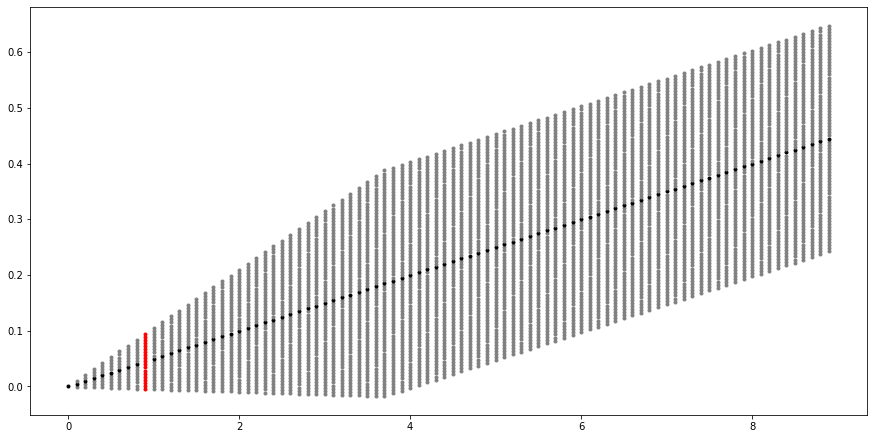

In [3]:
#tree構造に遷移確率とイールドカーブへのフィッティングを行っていない場合(theta=0)の場合の値格納
HW_tree=[{0:r_init}]
trans_prob_tree=[{0:[1/(2*h),1-1/h,1/(2*h)]}]
for i in range(1,N+1):
    node_num=min(int(Max_node),i)
    tmp_HW_tree={}
    tmp_trans_prob_tree={}
    for node in range(-node_num,node_num+1):
        #遷移確率の計算
        if node==Max_node:
            tmp_trans_prob=[1+(1/h+node**2*M**2+3*node*M)/2,-(1/h+node**2*M**2+2*node*M),(1/h+node**2*M**2+node*M)/2]
        elif node==-Max_node:
            tmp_trans_prob=[(1/h+node**2*M**2-node*M)/2,-(1/h+node**2*M**2-2*node*M),1+(1/h+node**2*M**2-3*node*M)/2]
        else:
            tmp_trans_prob=[(1/h+node**2*M**2+node*M)/2,1-1/h-node**2*M**2,(1/h+node**2*M**2-node*M)/2]
        
        #1時点内の各nodeを格納
        tmp_HW_tree[node]=a*delta_t*i+delta_r*node+r_init
        tmp_trans_prob_tree[node]=tmp_trans_prob
    
    #各時点のnodeをまとめた結果を格納
    HW_tree.append(tmp_HW_tree)
    trans_prob_tree.append(tmp_trans_prob_tree)

#フィッティング前のtreeの描画
plt.figure(figsize=(15,7.5))
for i in range(N+1):
    node_num=min(int(Max_node),i)
    for node in range(-node_num,node_num+1):
        if i==N_T:
            plt.plot(i*delta_t,HW_tree[i][node],".",color="red")
        elif node==0:
            plt.plot(i*delta_t,HW_tree[i][node],".",color="black")
        else:
            plt.plot(i*delta_t,HW_tree[i][node],".",color="gray")
plt.show()

In [4]:
#Arrow_Debreu証券の価格を格納する。
Arrow_Debreu_tree=copy.deepcopy(HW_tree)

#Arrow_Debreu_treeの初期値を設定
Arrow_Debreu_tree[0][0]=1.0
for i in range(1,len(Arrow_Debreu_tree)):
    for node in range(-(len(Arrow_Debreu_tree[i])-1)//2,(len(Arrow_Debreu_tree[i])-1)//2+1):
        Arrow_Debreu_tree[i][node]=0

#Arrow_Debreu証券の価格を計算する。
for i in range(len(Arrow_Debreu_tree)-1):
    for node in range(-(len(Arrow_Debreu_tree[i])-1)//2,(len(Arrow_Debreu_tree[i])-1)//2+1):
        if node==Max_node:
            up=node
            middle=node-1
            down=node-2
        elif node==-Max_node:
            up=node+2
            middle=node+1
            down=node
        else:
            up=node+1
            middle=node
            down=node-1
        Arrow_Debreu_tree[i+1][up]+=Arrow_Debreu_tree[i][node]*trans_prob_tree[i][node][0]
        Arrow_Debreu_tree[i+1][middle]+=Arrow_Debreu_tree[i][node]*trans_prob_tree[i][node][1]
        Arrow_Debreu_tree[i+1][down]+=Arrow_Debreu_tree[i][node]*trans_prob_tree[i][node][2]

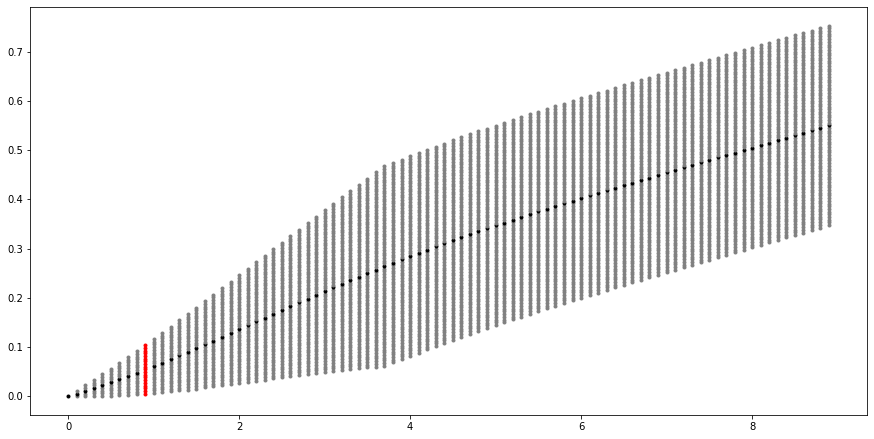

In [5]:
#イールドカーブへのフィッティングを行う。
for i in range(len(Arrow_Debreu_tree)):
    sum_tmp=0
    for node in range(-(len(Arrow_Debreu_tree[i])-1)//2,(len(Arrow_Debreu_tree[i])-1)//2+1):
        sum_tmp+=Arrow_Debreu_tree[i][node]*np.exp(-node*delta_r*delta_t)
    alpha=(np.log(sum_tmp)-np.log(discount_bond_price[i+1]))
    for node in range(-(len(Arrow_Debreu_tree[i])-1)//2,(len(Arrow_Debreu_tree[i])-1)//2+1):
        HW_tree[i][node]+=alpha

#フィッティング後のtreeの描画
plt.figure(figsize=(15,7.5))
for i in range(N+1):
    node_num=min(int(Max_node),i)
    for node in range(-node_num,node_num+1):
        if i==N_T:
            plt.plot(i*delta_t,HW_tree[i][node],".",color="red")
        elif node==0:
            plt.plot(i*delta_t,HW_tree[i][node],".",color="black")
        else:
            plt.plot(i*delta_t,HW_tree[i][node],".",color="gray")
plt.show()

### バックワード・インダクション

In [6]:
#プライシング結果を代入する変数を定義
pricing_tree=copy.deepcopy(HW_tree)
#pricing_treeの初期化
for i in range(len(pricing_tree)):
    for node in range(-(len(pricing_tree[i])-1)//2,(len(pricing_tree[i])-1)//2+1):
        if i<N_T:
            pricing_tree[i][node]=0
        else:
            if (i-N_T)%(delta_p/delta_t)==0:
                pricing_tree[i][node]=HW_tree[i][node]-S_Rate
            else:
                pricing_tree[i][node]=0

In [7]:
#pricing
for i in range(len(pricing_tree)-2,-1,-1):
    for node in range(-(len(pricing_tree[i])-1)//2,(len(pricing_tree[i])-1)//2+1):
        
        if node==(len(pricing_tree[i])-1)//2 and len(pricing_tree[i])==len(pricing_tree[i+1]):
            price_tmp=pricing_tree[i+1][node]*trans_prob_tree[i][node][0]
            price_tmp+=pricing_tree[i+1][node-1]*trans_prob_tree[i][node][1]
            price_tmp+=pricing_tree[i+1][node-2]*trans_prob_tree[i][node][2]
            
        elif node==-(len(pricing_tree[i])-1)//2 and len(pricing_tree[i])==len(pricing_tree[i+1]):
            price_tmp=pricing_tree[i+1][node+2]*trans_prob_tree[i][node][0]
            price_tmp+=pricing_tree[i+1][node+1]*trans_prob_tree[i][node][1]
            price_tmp+=pricing_tree[i+1][node]*trans_prob_tree[i][node][2]
            
        else:
            price_tmp=pricing_tree[i+1][node+1]*trans_prob_tree[i][node][0]
            price_tmp+=pricing_tree[i+1][node]*trans_prob_tree[i][node][1]
            price_tmp+=pricing_tree[i+1][node-1]*trans_prob_tree[i][node][2]
        pricing_tree[i][node]=price_tmp*np.exp(-HW_tree[i][node]*delta_t/100)+pricing_tree[i][node]
print(round(pricing_tree[0][0],2),"%")

3.75 %


### モンテカルロ法

In [8]:
#プライシング結果を代入する変数を定義
pricing_tree=copy.deepcopy(HW_tree)
#pricing_treeの初期化
for i in range(len(pricing_tree)):
    for node in range(-(len(pricing_tree[i])-1)//2,(len(pricing_tree[i])-1)//2+1):
        if i<N_T:
            pricing_tree[i][node]=0
        else:
            if (i-N_T)%(delta_p/delta_t)==0:
                pricing_tree[i][node]=HW_tree[i][node]-S_Rate
            else:
                pricing_tree[i][node]=0

In [9]:
N_monte=10000
price_list=[]
for i in range(N_monte):
    rand_list=np.random.rand(len(pricing_tree)-1)
    current_node=0
    price=pricing_tree[0][current_node]
    for j in range(len(rand_list)):
        if current_node==Max_node:
            if 0<=rand_list[j]<trans_prob_tree[j][current_node][0]:
                current_node=current_node
            elif trans_prob_tree[j][current_node][0]<=rand_list[j]<trans_prob_tree[j][current_node][0]+trans_prob_tree[j][current_node][1]:
                current_node=current_node-1
            else:
                current_node=current_node-2
        elif current_node==-Max_node:
            if 0<=rand_list[j]<trans_prob_tree[j][current_node][0]:
                current_node=current_node+2
            elif trans_prob_tree[j][current_node][0]<=rand_list[j]<trans_prob_tree[j][current_node][0]+trans_prob_tree[j][current_node][1]:
                current_node=current_node+1
            else:
                current_node=current_node
        else:
            if 0<=rand_list[j]<trans_prob_tree[j][current_node][0]:
                current_node=current_node+1
            elif trans_prob_tree[j][current_node][0]<=rand_list[j]<trans_prob_tree[j][current_node][0]+trans_prob_tree[j][current_node][1]:
                current_node=current_node
            else:
                current_node=current_node-1
        price+=pricing_tree[j+1][current_node]*np.exp(-HW_tree[j+1][current_node]*delta_t/100)
    price_list.append(max(price,0))
print(round(np.mean(price_list),2),"%")

3.81 %
